In [2]:
import functools
import qiskit_dynamics as qk_d
import qiskit.providers.fake_provider as qk_fp
import numpy as np
import csv
import qiskit
import matplotlib.pyplot as plt

from qiskit.quantum_info import Operator, process_fidelity

In [3]:
import sys
sys.path.append("../")
from pulse_simulator.simulator import Simulator
import pulse_simulator as ps

In [5]:
backend = qk_fp.FakeManila()
units = 1e9
ns = units
dt = backend.configuration().dt * ns

In [43]:
registers = [i for i in range(2)]
config_vars = ps.backend_simulation_vars(backend, rabi=False, units=units)

H_rx = functools.partial(
    ps.rx_model,
    registers=registers,
    backend=backend,
    variables=config_vars,
    rotating_frame=True,
)

Hs_control = []
Hs_channels = []
for qubit in registers:
    Hj_drift, Hjs_control, Hjs_channel = H_rx(qubit)
    Hs_control += Hjs_control
    Hs_channels += Hjs_channel

In [44]:
good_pulses = "../pico-pulses/saved-pulses-2023-12-13/a_single_qubit_gateset_R1e-3.csv"
default_pulses = "../pico-pulses/saved-pulses-2023-12-13/a_single_qubit_gateset_default.csv"

In [45]:
def get_simulated_fidelity(sim, qc, file_name):
    gates = []
    with open(file_name) as file:
        reader = csv.reader(file)
        for row in reader:
            gates.append(np.array([float(x) for x in row]))

    # expected_angles = [np.pi / 2, np.pi / 2, np.pi / 4, np.pi / 4]
    # for i in range(len(gates)):
    #     normalization = np.trapz(gates[i], dx=dt) / expected_angles[i]
    #     gates[i] = gates[i] / normalization

    for pulse, name in zip(gates, ["x_blue", "x_red", "sx_blue", "sx_red"]):
        pulse = qiskit.pulse.Waveform(pulse, limit_amplitude=False)
        sim.set_pulse(name, pulse)

    expected = Operator(qc)
    out = sim.simulate_circuit(qc)
    return process_fidelity(out, expected)

In [46]:
qc = qiskit.QuantumCircuit(2)
qc.x(0)
qc.x(1)
qc.draw()

┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘

In [47]:
default_gates = []
with open(default_pulses) as file:
    reader = csv.reader(file)
    for row in reader:
        default_gates.append(np.array([float(x) for x in row]))

x_blue_default = qiskit.pulse.Waveform(default_gates[0])
x_red_default = qiskit.pulse.Waveform(default_gates[1])

In [48]:
robust_gates = []
with open(good_pulses) as file:
    reader = csv.reader(file)
    for row in reader:
        robust_gates.append(np.array([float(x) for x in row]))

x_blue_robust = qiskit.pulse.Waveform(robust_gates[0])
x_red_robust = qiskit.pulse.Waveform(robust_gates[1])

In [49]:
default_fidelities = []
good_fidelities = []
strength_array = np.arange(0, 0.05, 0.001)

X = np.array([[0, 1], [1, 0]])

with qiskit.pulse.build(name="Default moment") as pulse_default:
    channel0 = qiskit.pulse.DriveChannel(0)
    channel1 = qiskit.pulse.DriveChannel(1)
    qiskit.pulse.play(x_blue_default, channel0)
    qiskit.pulse.play(x_red_default, channel1)

with qiskit.pulse.build(name="Robust moment") as pulse_robust:
    channel0 = qiskit.pulse.DriveChannel(0)
    channel1 = qiskit.pulse.DriveChannel(1)
    qiskit.pulse.play(x_blue_robust, channel0)
    qiskit.pulse.play(x_red_robust, channel1)

for strength in strength_array:
    Z_op = np.array([[1, 0], [0, -1]])

    solver = qk_d.Solver(
        # static_hamiltonian=Z_op * strength,
        static_hamiltonian=qiskit.quantum_info.Operator(np.kron(Z_op, Z_op) * strength),
        hamiltonian_operators=Hs_control,
        static_dissipators=None,
        rotating_frame=None,
        rwa_cutoff_freq=None,
        hamiltonian_channels=Hs_channels,
        channel_carrier_freqs={ch: 0.0 for ch in Hs_channels},
        dt=dt,
    )
    solver.model.evaluation_mode = 'dense'

    # sim = ps.simulator.Simulator(
    #     basis_gates=["rz", "sx", "x", "cx"], solver=solver, backend=backend
    # )

    U0 = ps.qiskit_identity_operator(2)
    expected = qiskit.quantum_info.Operator(np.kron(X, X))

    sol = solver.solve(
        t_span=[0.0, 50 * (2 / 9)],
        y0=U0,
        signals=pulse_default,
        max_dt=dt,
        t_eval=[0, 50 * (2 / 9)],
        method="jax_expm",
        magnus_order=1,
    )
    default_fidelities.append(process_fidelity(sol.y[-1], expected))

    sol = solver.solve(
        t_span=[0.0, 50 * (2 / 9)],
        y0=U0,
        signals=pulse_robust,
        max_dt=dt,
        t_eval=[0, 50 * (2 / 9)],
        method="jax_expm",
        magnus_order=1,
    )
    good_fidelities.append(process_fidelity(sol.y[-1], expected))

    # default_fidelities.append(1 - get_simulated_fidelity(sim, qc, default_pulses))
    # good_fidelities.append(1 - get_simulated_fidelity(sim, qc, good_pulses))

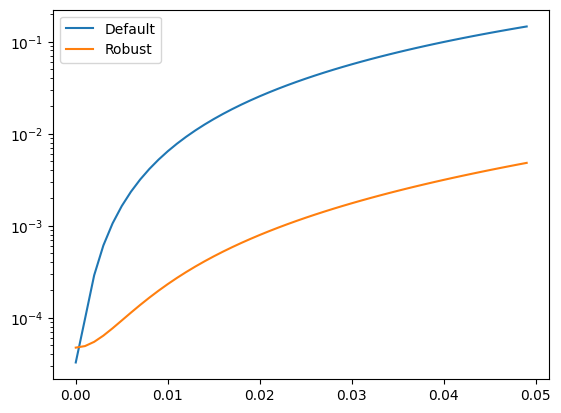

In [51]:
plt.plot(strength_array, 1 - np.array(default_fidelities), label="Default")
plt.plot(strength_array, 1 - np.array(good_fidelities), label="Robust")
plt.yscale("log")
plt.legend();

### Qutip

In [52]:
import qutip

In [53]:
I = np.array([[1, 0], 
              [0, 1]], dtype="complex128")
Z = np.array([[1, 0], 
              [0, -1]], dtype="complex128")
X = np.array([[0, 1], 
              [1, 0]], dtype="complex128")

# 1 qubit
# if Hj_drift == 0:
#     H_t_ind = 0 * qutip.Qobj(I)
# else:
#     H_t_ind = qutip.Qobj(Hj_drift.data)
# H_t_ind += 0.001 * qutip.Qobj(Z)

# 2 qubit
if Hj_drift == 0:
    H_t_ind = 0 * qutip.Qobj(np.kron(I, I))
else:
    H_t_ind = qutip.Qobj(Hj_drift.data)
H_t_ind += 0.01 * qutip.Qobj(np.kron(Z, Z))

In [54]:
times =  np.arange(0, 50) * 2/ 9

In [55]:
robust_gates = []
default_gates = []

with open(good_pulses) as file:
    reader = csv.reader(file)
    for row in reader:
        robust_gates.append(np.array([float(x) for x in row]))

with open(default_pulses) as file:
    reader = csv.reader(file)
    for row in reader:
        default_gates.append(np.array([float(x) for x in row]))


# expected_angles = [np.pi / 2, np.pi / 2, np.pi / 4, np.pi / 4]
# for i in range(len(robust_gates)):
#     normalization = np.trapz(robust_gates[i], dx=dt) / expected_angles[i]
#     robust_gates[i] = robust_gates[i] / normalization

# expected_angles = [np.pi / 2, np.pi / 2, np.pi / 4, np.pi / 4]
# for i in range(len(default_gates)):
#     normalization = np.trapz(default_gates[i], dx=dt) / expected_angles[i]
#     default_gates[i] = default_gates[i] / normalization

x_blue_default = default_gates[0]
x_red_default = default_gates[1]

x_blue_robust = robust_gates[0]
x_red_robust = robust_gates[1]

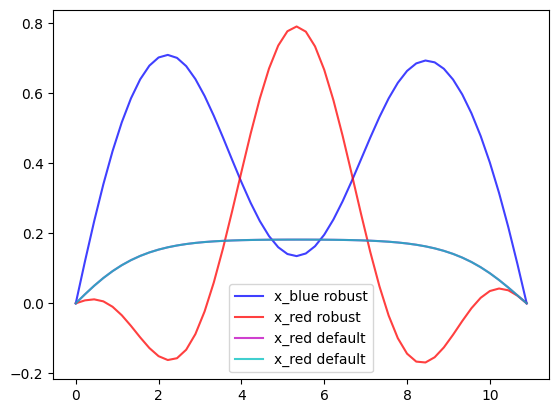

In [56]:
plt.plot(times, x_blue_robust, color="blue", label="x_blue robust", alpha=0.75)
plt.plot(times, x_red_robust, color="red", label="x_red robust", alpha=0.75)
plt.plot(times, x_red_default, color="m", label="x_red default", alpha=0.75)
plt.plot(times, x_blue_default, color="c", label="x_red default", alpha=0.75)
plt.legend();

In [57]:
H_0_control = qutip.Qobj(Hs_control[0].data)
H_1_control = qutip.Qobj(Hs_control[1].data)
H = [H_t_ind, [H_0_control, x_blue_default], [H_1_control, x_red_default]]
psi0 = qutip.Qobj(np.kron(I, I))

result = qutip.sesolve(H=H, psi0=psi0, tlist=times)

In [58]:
expected = qutip.Qobj(np.kron(X, X))

In [59]:
np.abs(np.real((result.states[-1].dag() * expected).tr() / 4))

0.9969277395109897

In [60]:
robust_fidelities = []
default_fidelities = []
strength_array = np.arange(0, 0.05, 0.001)

ZZ_op = qutip.Qobj(np.kron(Z, Z))
H_0_control = qutip.Qobj(Hs_control[0].data)
H_1_control = qutip.Qobj(Hs_control[1].data)
psi0 = qutip.Qobj(np.kron(I, I))

times = np.arange(0, 50) * 2/ 9

for strength in strength_array:
    # testing ζ Z Z + u_1 (t) I X + u_2 (t) X I
    if Hj_drift == 0:
        H_t_ind = 0 * qutip.Qobj(np.kron(I, I))
    else:
        H_t_ind = qutip.Qobj(Hj_drift.data)
    H_t_ind += strength * ZZ_op

    H_default = [H_t_ind, [H_0_control, x_blue_default], [H_1_control, x_red_default]]
    H_robust = [H_t_ind, [H_0_control, x_blue_robust], [H_1_control, x_red_robust]]

    default_result = qutip.sesolve(H=H_default, psi0=psi0, tlist=times)
    robust_result = qutip.sesolve(H=H_robust, psi0=psi0, tlist=times)

    default_fidelities.append(np.abs(np.real((default_result.states[-1].dag() * expected).tr() / 4)))
    robust_fidelities.append(np.abs(np.real((robust_result.states[-1].dag() * expected).tr() / 4)))

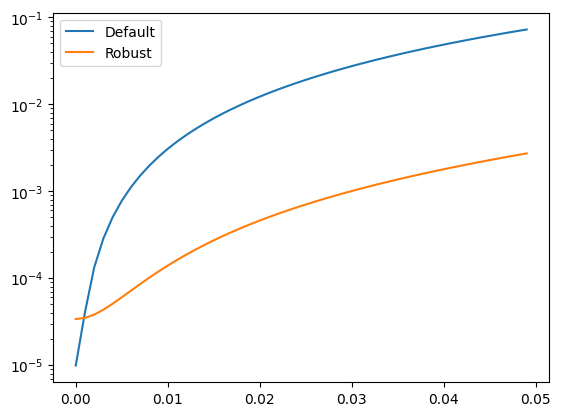

In [61]:
plt.plot(strength_array, 1 - np.array(default_fidelities), label="Default")
plt.plot(strength_array, 1 - np.array(robust_fidelities), label="Robust")
plt.yscale("log")
plt.legend();